# InstaCart Market Basket Analysis
<hr style="border:2px solid gray">

### 簡介

本報告的宗旨在於通過在 Kaggle 競賽中 Instacart 提供的顧客訂單數據，預測哪些曾購買過的商品會在顧客的下一次訂單中再次出現，藉此改善產品推薦系統，從而提升顧客的購物體驗和滿意度。

kaggle 競賽網址:https://www.kaggle.com/competitions/instacart-market-basket-analysis

### 核心目標

屬於二元分類問題。對於每一位顧客而言，我們需要預測每一項他們曾經購買過的產品是否會在下一份訂單中再次購買（是=1；否=0）。為了實現這一目標，我們會從顧客先前的訂單中建立多項特徵，並進行建模來預測。

# 一、數據集說明
<hr style="border:2px solid gray">

該資料集是匿名的，包含來自超過 20 萬 Instacart 用戶的 300 多萬份雜貨訂單的樣本數據。以下是各個數據檔之間的關係圖：

![數據關係圖](./instacartFiles.png)

圖片來源：https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/33128

In [1]:
# 載入所需套件
import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 清理暫存
gc.collect()
# 讀取各個數據集
order_products_prior_df = pd.read_csv('./datasets/order_products__prior.csv')
order_products_train_df = pd.read_csv('./datasets/order_products__train.csv')
orders_df = pd.read_csv('./datasets/orders.csv')
products_df = pd.read_csv('./datasets/products.csv')
aisles_df = pd.read_csv('./datasets/aisles.csv')
departments_df = pd.read_csv('./datasets/departments.csv')

### 1-1. 訂單數據集（orders_df）

InstaCart 將主要訂單數據分為三個部分：prior、train 和 test。

- **prior**：包含顧客過去的所有訂單記錄。
- **train**：用於訓練模型的數據集。
- **test**：用於測試模型的數據集。

`orders_df` 的數據集包含了以下的欄位：

- **order_id**: 訂單編號（Primary key）
- **user_id**: 客戶編號（Primary key）
- **eval_set**: 表示屬於哪個集合（prior、train 或 test）
- **order_number**: 客戶的訂單次數
- **order_dow**: 訂單的禮拜
- **order_hour_of_day**: 訂單的時間(小時)
- **days_since_prior_order**: 距離上次訂單的天數

以下是 `orders_df` 的前五行數據：

In [3]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


※ days_since_prior_order 為 NaN 表示其第一次購買。

### 1-2. 訂單產品的數據集（order_products_prior_df 和 order_products_train_df）

`order_products_prior_df` 和 `order_products_train_df` 的數據集包含了以下的欄位：

- **order_id**: 訂單編號（Primary key）
- **product_id**: 商品編號（Primary key）
- **add_to_cart_order**: 加入購物車的順序
- **reordered**: 是否重複購買（1 表示重複購買，0 表示首次購買）

以下是 `order_products_prior_df` 和 `order_products_train_df` 的前五行數據：

In [4]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### 1-3. 產品數據集（products_df）

`products_df` 包含了以下的欄位：

- **product_id**: 產品標號（Primary key）
- **product_name**: 產品名稱
- **aisle_id**: 通道編號（Primary key）
- **department_id**: 部門編號（Primary key）

以下是 `products_df` 的前五行數據：

In [6]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### 1-4. 通道數據集（aisles_df）
`aisles_df` 包含了以下欄位：

- **aisle_id**: 通道編號（Primary key）
- **aisle**: 通道名稱

以下是 `aisles_df` 的前五行數據：

In [7]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### 1-5. 部門數據集（departments_df）
`departments_df` 包含了以下欄位：

- **department_id**: 部門編號（Primary key）
- **department**: 部門名稱

以下是 `departments_df` 的前五行數據：

In [8]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### 1-6. 數據合併

我們將使用商品、公道及部門編號對 order_products_prior_df 進行合併。

合併過程如下：

In [9]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


# 二、EDA 探索性資料分析
<hr style="border:2px solid gray">

### 2-1. 訂單數據集的數量

在訂單數據集中涵括了 `prior`（過去購買紀錄）、`train` 和 `test`，總共約有三百多萬筆數據。

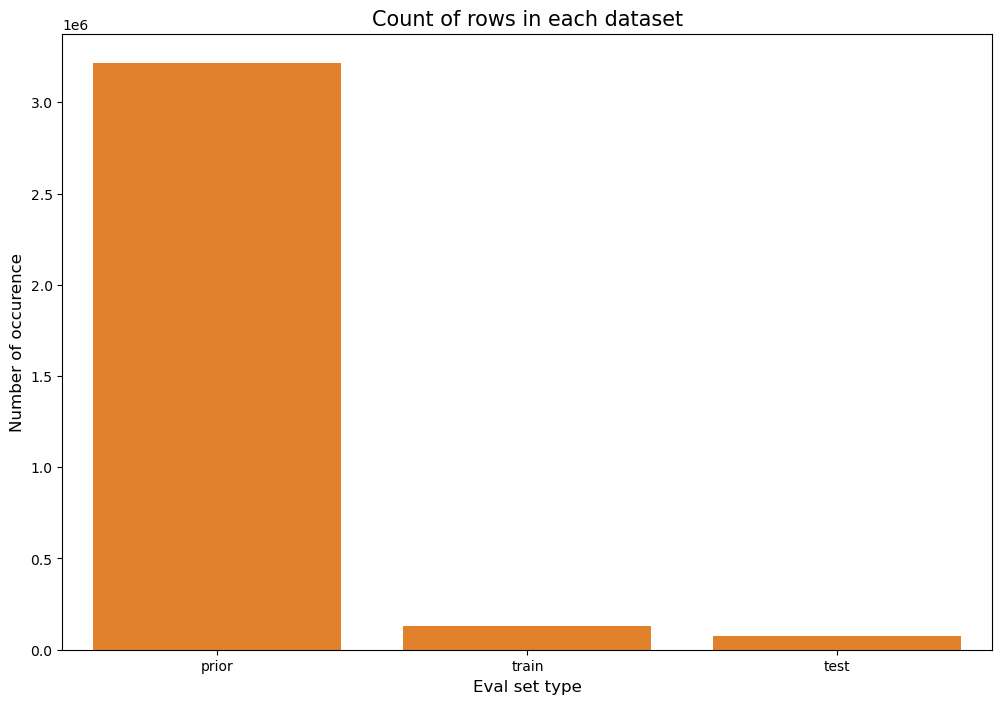

In [10]:
# 定義一個調色盤
color = sns.color_palette()
# 計算每個資料集的列數
data_counts = orders_df['eval_set'].value_counts()
# 長條圖的圖像化
plt.figure(figsize=(12, 8))
sns.barplot(x=data_counts.index, y=data_counts.values, color=color[1])
plt.ylabel('Number of occurence' , fontsize = 12 )
plt.xlabel('Eval set type' , fontsize = 12)
plt.title('Count of rows in each dataset' , fontsize = 15)
plt.xticks()
plt.show()

### 2-2. 計算每個資料集中的顧客數量

我們可以通過計算每個資料集中顧客的數量來了解數據中的顧客分佈情況。

在 `orders_df` 表中，總共有 206,209 位顧客，其中 131,209 位顧客作為訓練集，其餘 75,000 位顧客作為測試集，比例大概是 65：35。

In [11]:
# 取得各個資料集中的客戶數量
def get_unique_count(x):
    return len(np.unique(x))

print(orders_df.groupby('eval_set')['user_id'].aggregate(get_unique_count))

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64


### 2-3. 顧客過去的總訂單數

如果是購買單數較多的顧客，會比較難預測他的購物習慣為何，反之如果購物單數較少的顧客，消費模式通常較為單純。

我們將對每個顧客找到他們下的最大 `order_number`，表示為其總共的訂單數，並統計這些訂單數出現的次數。

由下圖可以觀察到，最低是 3 筆訂單，最高則是 99 筆，但是因為 99 筆的量過高，因此他看起來像是數據處理過程中的一部分，而不像是原始的數據，可以合理懷疑是資料處理的團隊將大於 99 的資料全部歸類在 99 所導致的結果。

實際分析遇到這種情況，可以直接去跟 BI 部門的人做確認。

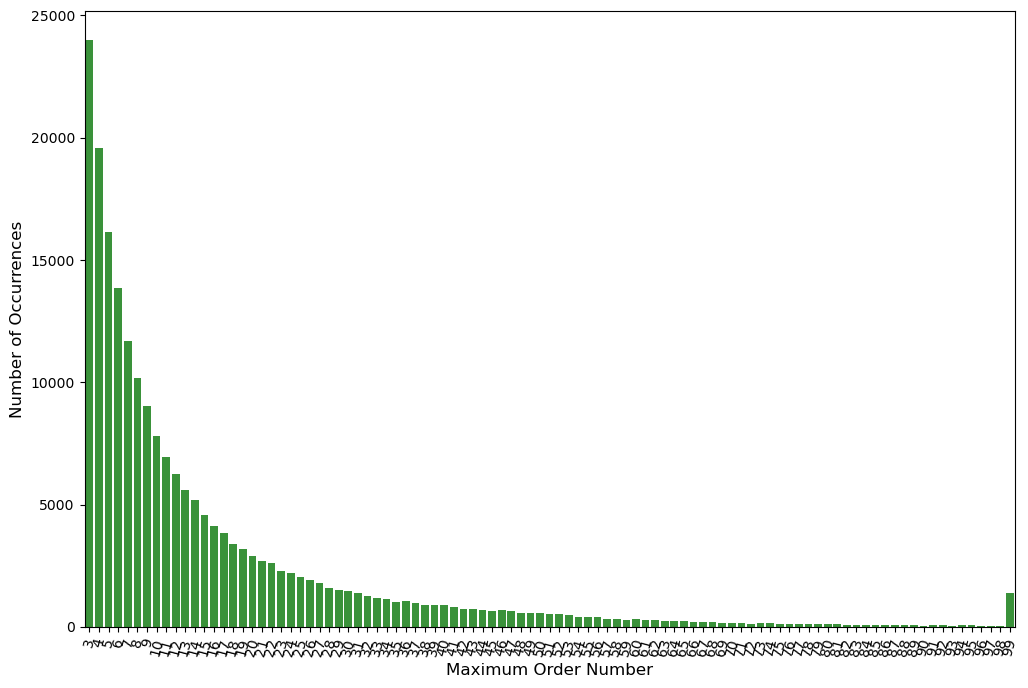

In [12]:
# 選取 eval_set 為 prior 的訂單
prior_orders_df = orders_df[orders_df['eval_set'] == 'prior']
# 對每個顧客，找到他們最大的 order_number，表示為其總共的訂單數
order_count = prior_orders_df.groupby('user_id')['order_number'].aggregate(np.max).reset_index()
# 統計這些訂單數出現的次數
order_count = order_count.order_number.value_counts()
# 畫出訂單數量的分佈情況
plt.figure(figsize=(12, 8))
sns.barplot(x=order_count.index, y=order_count.values, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum Order Number', fontsize=12)
plt.xticks(rotation=75)
plt.show()

### 2-4. 各禮拜的訂單人數
超市是相對較短週期的產業，所以掌握一個禮拜中最多人的天數是非常重要的，也可以在比較多人的天數中進行活動，增加顧客的消費。

假設第 0 天為禮拜一，第 1 天為禮拜二，以此類推。

由下圖可以發現一週中禮拜一和二是最多人購買的天數，而禮拜五則是最少。

Text(0.5, 1.0, 'Frequency of order by week day')

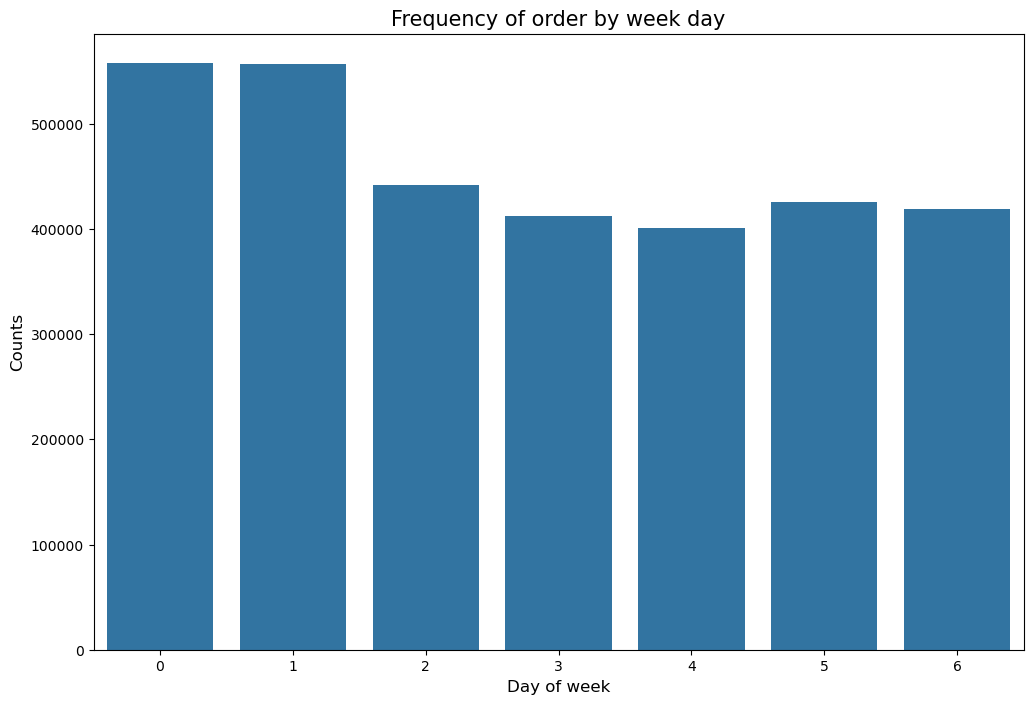

In [13]:
plt.figure(figsize  = (12, 8 ))
sns.countplot(x = 'order_dow' , data = prior_orders_df , color= color[0])
plt.ylabel('Counts' , fontsize = 12)
plt.xlabel('Day of week' , fontsize = 12 )
plt.xticks(rotation = 0)
plt.title("Frequency of order by week day" , fontsize = 15)

### 2-5. 各個時段的訂單數量
由下圖可觀察，基本上人潮會發生在上午 9 點至下午 5 點之間，值得一提的是大部分的訂單都是在白天進行。

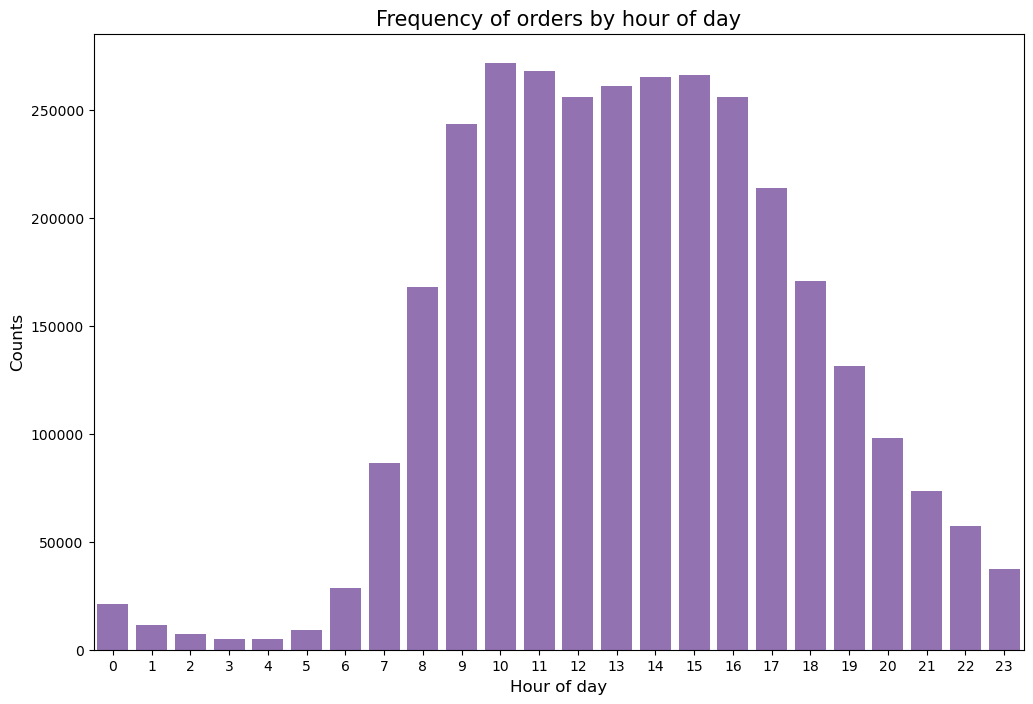

In [14]:
# 按一天中時段的訂單數量分佈
# 因為小時的資料最多到24個，所以還是可以用柱狀圖
plt.figure(figsize=(12, 8))
sns.countplot(x='order_hour_of_day', data=prior_orders_df, color=color[4])
plt.ylabel('Counts', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Frequency of orders by hour of day", fontsize=15)
plt.show()

### 2-6. 哪個禮拜的哪個時段是最多訂單的呢？

由以下的熱點圖，我們發現**禮拜二的10點是是最熱門的時段**。整體來看，可以說**禮拜一的下午和禮拜二的早上是下單的黃金時段**。

業者可以在禮拜一下午多準備新鮮的蔬果、麵包配合下午茶時間打造健康的點心時光，而禮拜二早晨也可以推出不同風味的咖啡來搭配不同的早餐組合來配合顧客的生活習慣。

具體來說還是必須通過訪問和調查，從顧客的角度來了解他們的偏好，從而真正得到影響購物時段的關鍵因素是什麼。

C:\Users\KevinLin\AppData\Local\Temp\ipykernel_4116\3919973134.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')


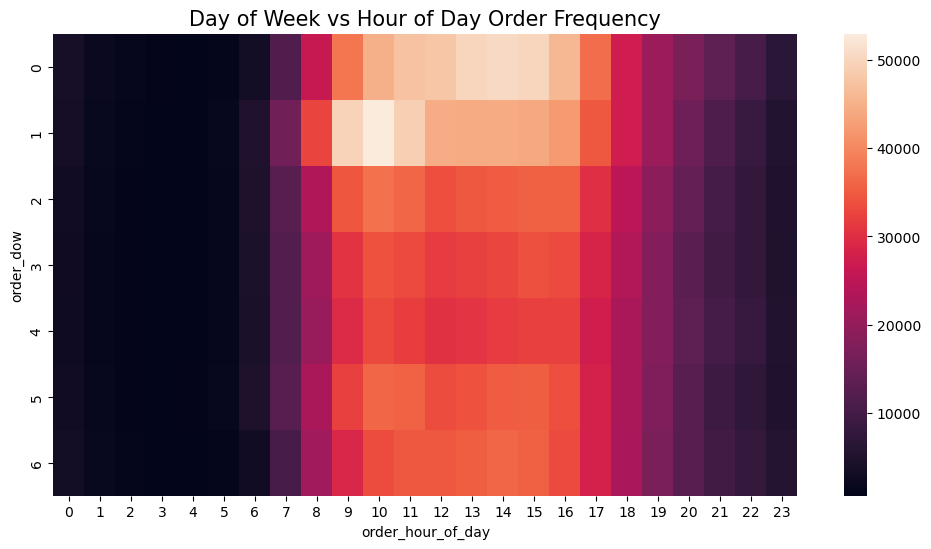

In [15]:
# 熱點圖顯示出星期和時段之間的關係
grouped_df = prior_orders_df.groupby(['order_dow', 'order_hour_of_day'])['order_number'].aggregate('count').reset_index()
# pivot 它會將列跟行的值轉換為新的列標題和行標題，並對數據進行重新排列，使得數據的結構更容易視覺化
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')
plt.figure(figsize=(12, 6))
sns.heatmap(grouped_df)
plt.title('Day of Week vs Hour of Day Order Frequency', fontsize=15)
plt.show()

### 2-7. 哪個購買間隔天數是最多人的呢？
可以預先**假設固定購買頻率的顧客應該是同一群人**，可能是習慣每週購物的家庭或者餐飲業者，他們需要定期補充食材和用品。**這些人的購物模式會比較好預測**，因為他們的購物行為具有一定的規律性。

由下圖我們可以觀察到以下的重點：

    1. 每一週（七天）購買的頻是最高的：表示許多顧客習慣每週購物一次。

    2. 14 天、21 天的頻率相對前後的時間點也較高：同樣是以＂週＂為單位的購物行為。

    3. 0 天表示有些人一天購物兩次：可以解釋成是因為忘記買某些東西而回去補買。

    4. 30 天的數據異常高：這很有可能是數據處理的一部分，把超過 30 天沒有購物的數據，統一歸類為 30 天。

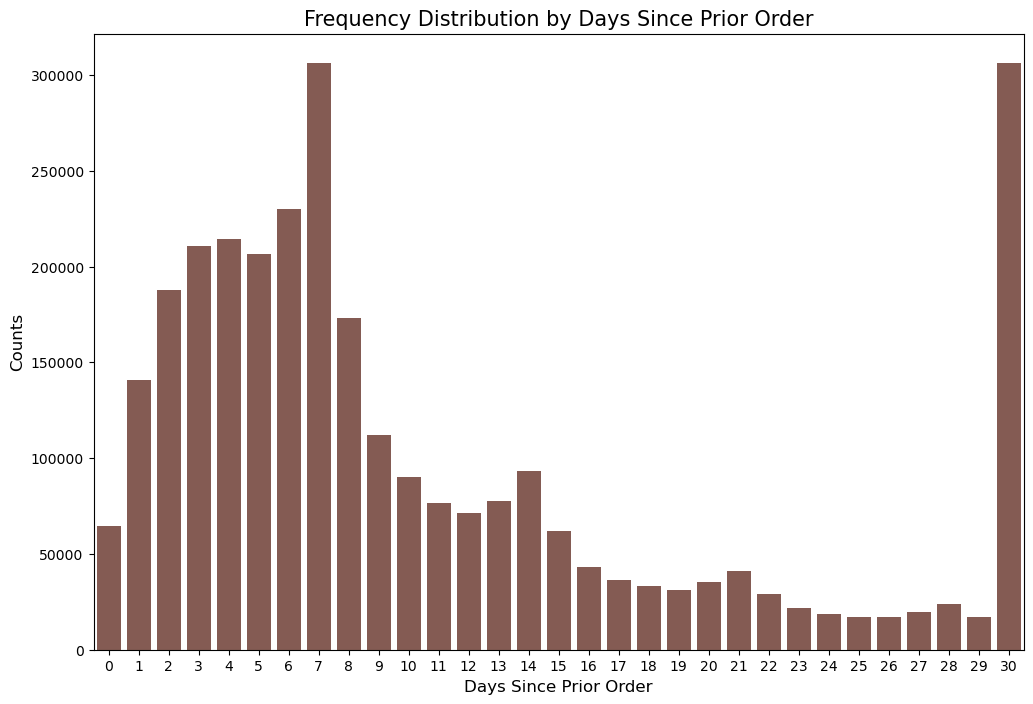

In [16]:
plt.figure(figsize=(12, 8))
sns.countplot(x='days_since_prior_order', data=prior_orders_df, color=color[5])
plt.xlabel('Days Since Prior Order', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Frequency Distribution by Days Since Prior Order', fontsize=15)
plt.xticks(ticks=range(31), labels=[str(i) for i in range(31)])  # 設置 x 軸刻度為 0 到 30 的整數
plt.show()

### 2-8. 顧客購買相同產品的比例是多少？

算出來的重購率大約是0.6，等於說顧客有超過五成的機率會購買之前就買過的產品。

In [17]:
# 計算重複購買的比例
reorder_ratio_prior = order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]
print(f'Prior 重複購買比例: {reorder_ratio_prior}')

Prior 重複購買比例: 0.5896974667922161


### 2-9. 每筆訂單購買的產品數量

由下圖可知，顧客大概都買四到七樣產品，最多人購買的數量為五樣。

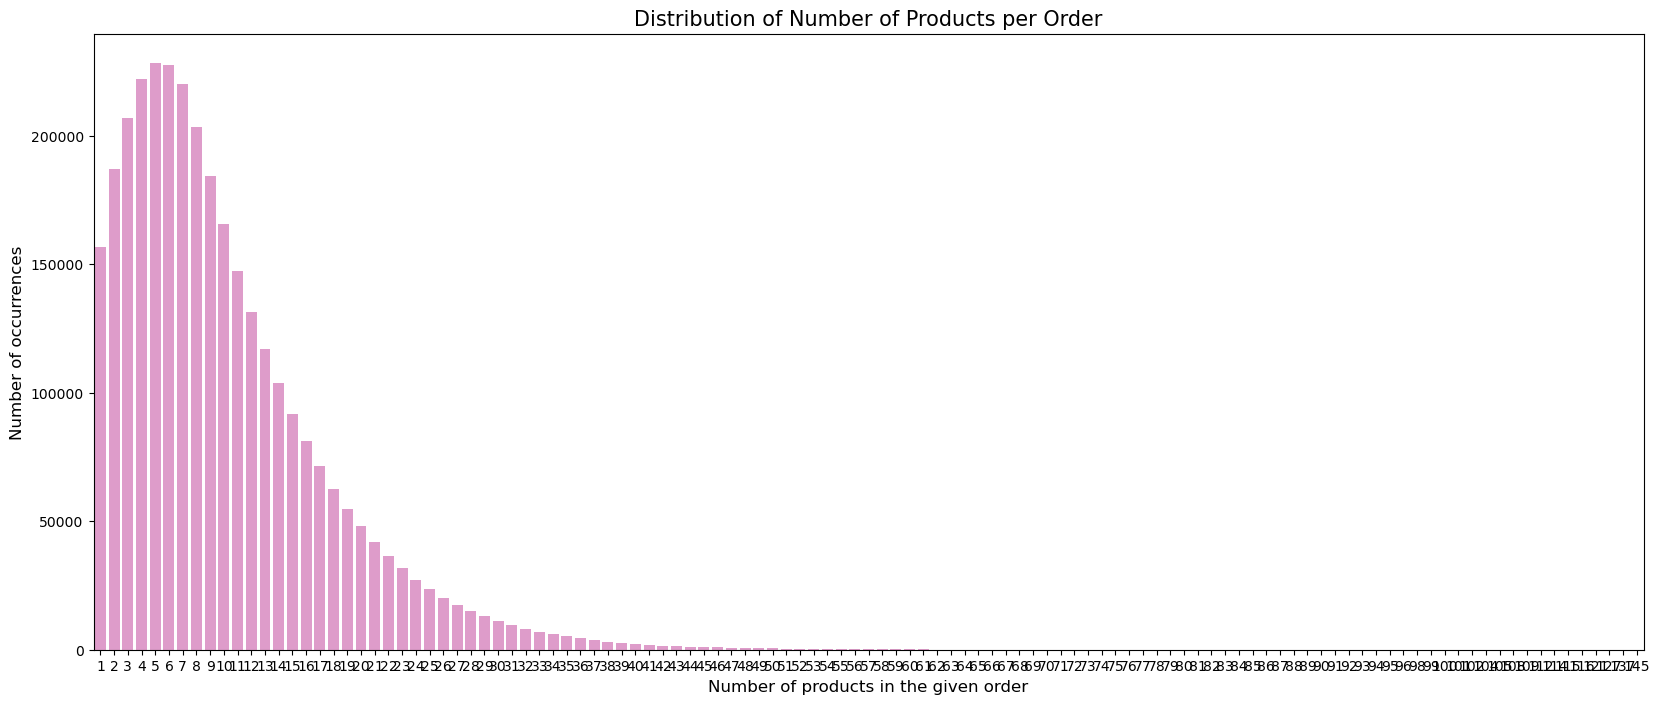

In [18]:
# 計算每個訂單中商品的數量
grouped_df = order_products_prior_df.groupby('order_id')['add_to_cart_order'].aggregate('max').reset_index() # 只要查看 add_to_cart_order 的 max 就可以知道這一訂單總共有多少個產品！
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[6])
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.title('Distribution of Number of Products per Order', fontsize=15)
plt.xticks(rotation=0)
plt.show()

### 2-10. 哪些商品最熱銷呢？

由下圖可知，有機或健康的產品非常熱銷，尤其是水果，可見 Instacart 主打的是健康產品，又或者是說隨著現代人越來越重視健康，促使有機健康的產品銷售有顯著的提升。

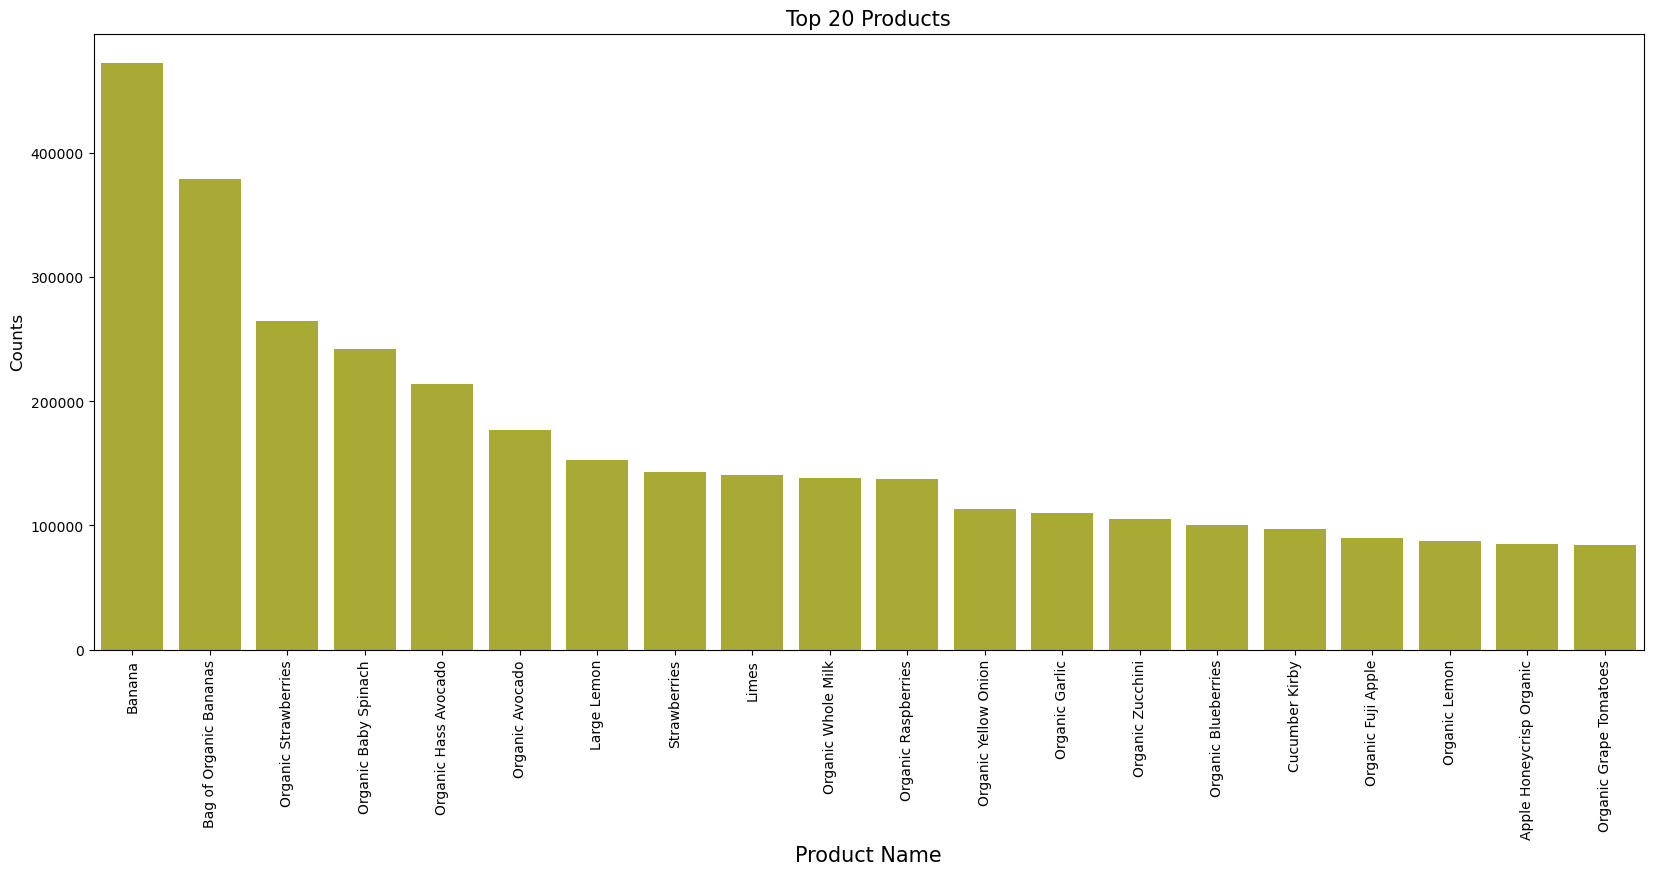

In [19]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20) # 前二十最熱銷(購買次數最多)的產品
cnt_srs.columns = ['product name' , 'frequency_count']

plt.figure(figsize=(20, 8))
sns.barplot(x='product name', y='frequency_count', data=cnt_srs, color=color[8])
plt.ylabel('Counts', fontsize=12)
plt.xlabel('Product Name', fontsize=15)
plt.title('Top 20 Products', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [20]:
cnt_srs

,product name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


### 2-11. 購買次數最多的通道為何？

已知水果、蔬菜和優格等健康的食物是 Instacart 的主打，因此其相關的通道購買次數也會相對較高。

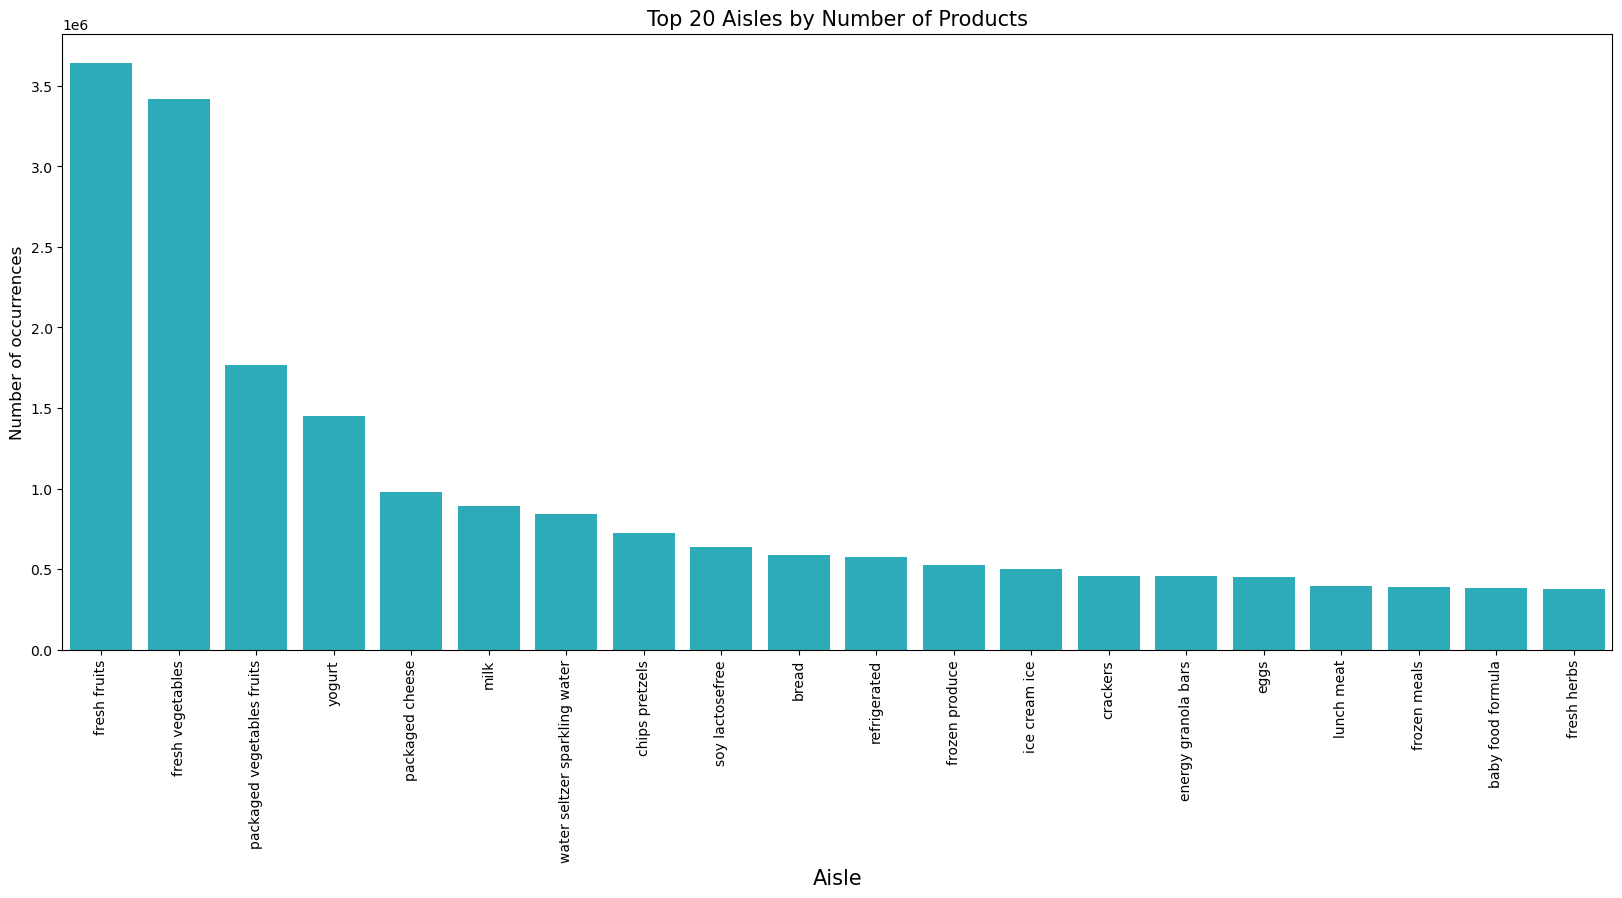

In [21]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20) # 計算每個通道的商產品銷量，並選取前20個

plt.figure(figsize=(20, 8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, color=color[9])
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=15)
plt.title('Top 20 Aisles by Number of Products', fontsize=15)
plt.xticks(rotation=90)
plt.show()

### 2-12. 各部門的銷量為何？
由下圖可知，農產品和日常雞蛋是銷售占比最大的部門，所以除了農產品之外，乳製品、蛋類等蛋白質食物也賣得不錯。

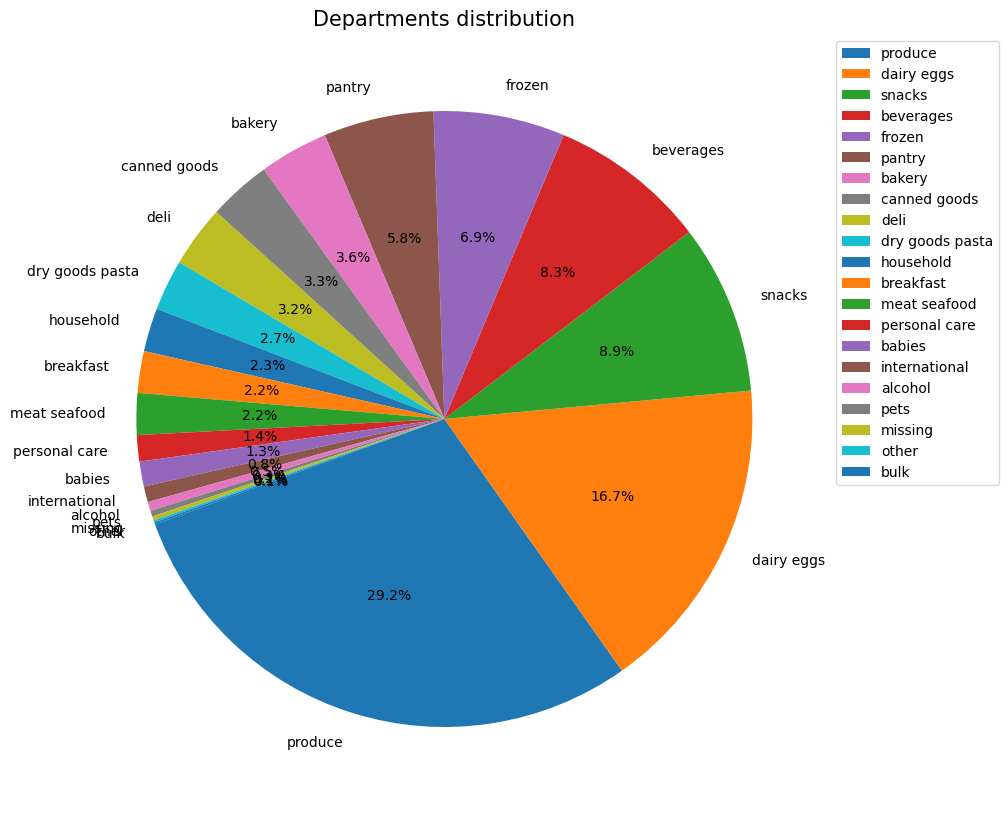

In [22]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200,
        textprops={'fontsize': 10}, labeldistance=1.1)

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Departments distribution", fontsize=15)
plt.show()

### 2-13. 各部門讓顧客重複購買的百分比為何？

由下圖可知，個人護理品的重複購買比例最低，而日常雞蛋的重複購買比例最高。

個人照護的產品重購率最差，很有可能是產品的品質欠佳，導致顧客重複購買的意願降低。必須要再進一步進行市場調查，藉此改善重購率較低的問題。

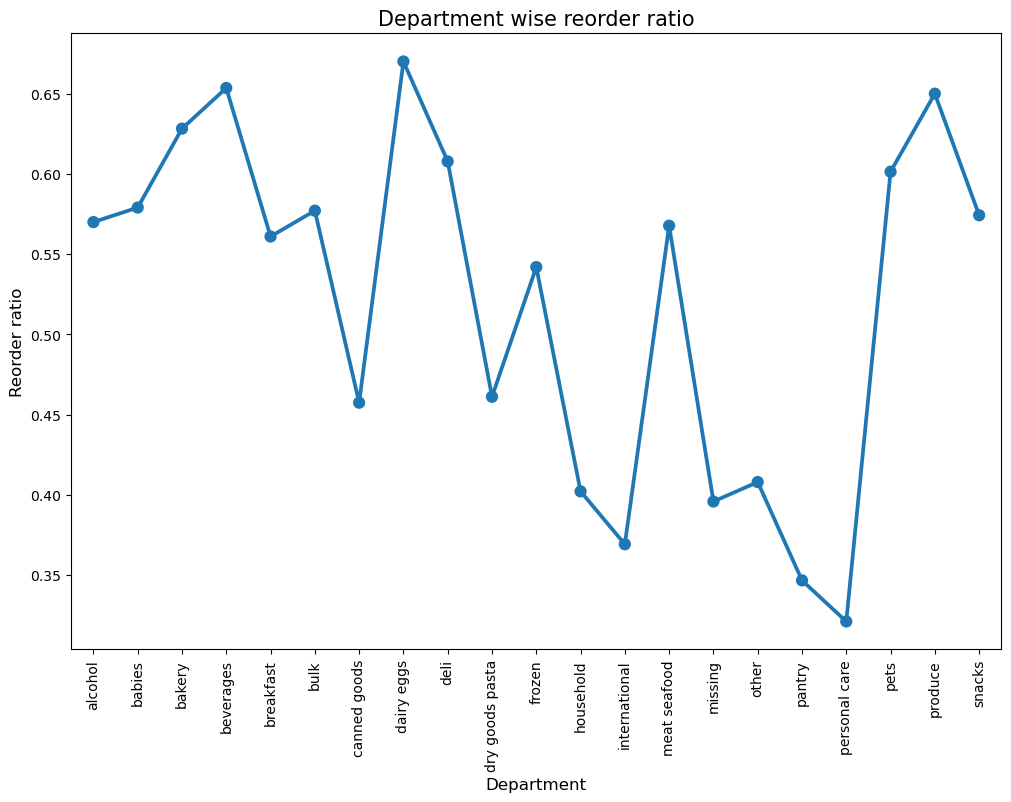

In [23]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df['department'].values, y=grouped_df['reordered'].values, color=color[0])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

### 2-14. 加入購物車的順序與重新訂購的比例

由下圖可知，**最初添加到購物車的產品與後續添加的產品相比，更有可能會是重複購買過的產品**。

直覺來說，我們都會傾向先把預先想好要買的產品，加入購物車後再慢慢逛商店。

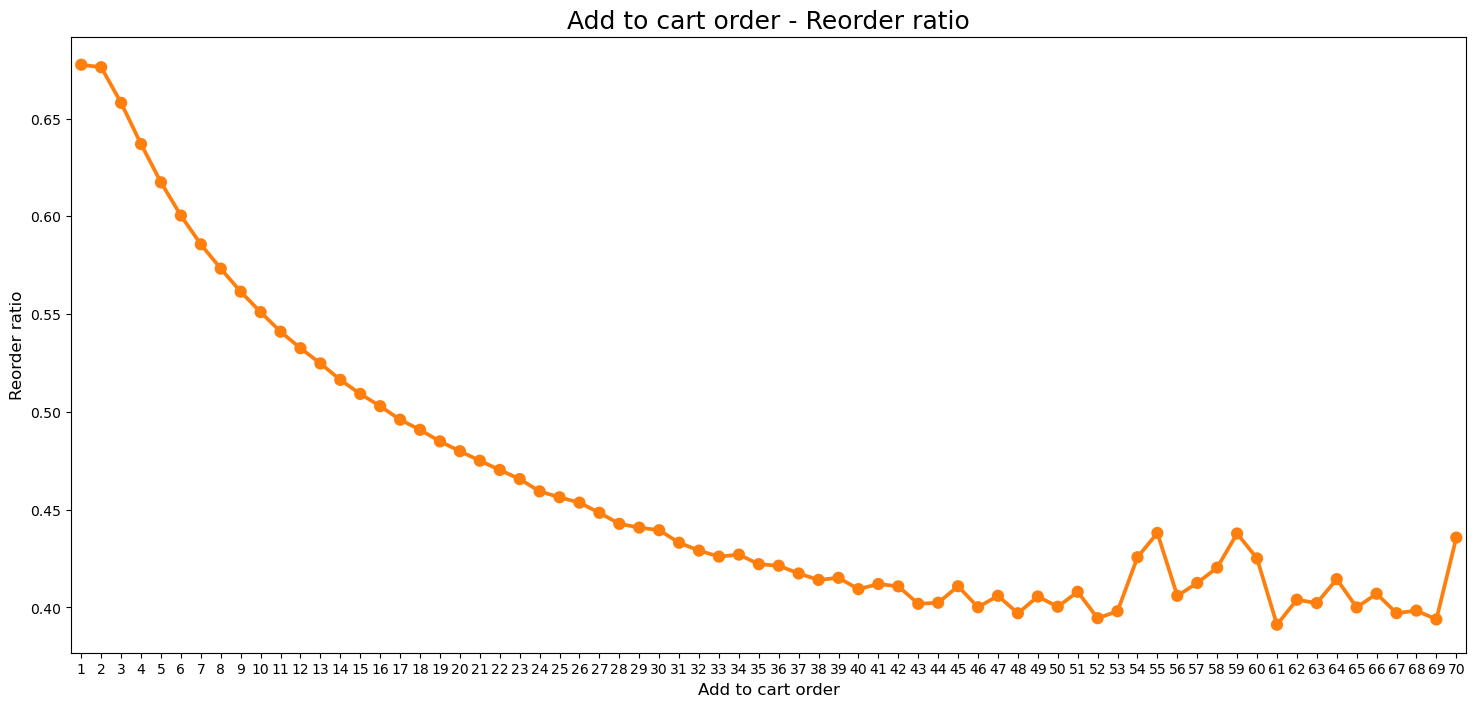

In [24]:
# 計算 'add_to_cart_mod' 的重複購買比例
# 複製一份 DataFrame
order_products_prior_df['add_to_cart_mod'] = order_products_prior_df['add_to_cart_order'].copy()
# 將 'add_to_cart_order' 超過 70 的值設置為 70
order_products_prior_df.loc[order_products_prior_df['add_to_cart_mod'] > 70, 'add_to_cart_mod'] = 70
grouped_df = order_products_prior_df.groupby('add_to_cart_mod')['reordered'].aggregate('mean').reset_index()
# 畫出 'add_to_cart_mod' 和 'reordered' 的關係圖
plt.figure(figsize=(18, 8))
sns.pointplot(x=grouped_df['add_to_cart_mod'].values, y=grouped_df['reordered'].values, color=color[1])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title('Add to cart order - Reorder ratio', fontsize=18)
plt.show()